# Player Detection and Tracking with YOLOv8
## POC: Hockey player detection and tracking with a small custom dataset
The goal of this notebook is to use YOLOv8 with Ultralytics lib to detect and make a simple tracking of hockey player with a custom dataset using 22/23 French Elite championship game video from RCF.

In [ ]:
# Install YOLOv8 lib & other libs
!pip install ultralytics
!pip install roboflow
!pip install clearml

In [10]:
from roboflow import Roboflow
import clearml
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
import numpy as np

In [ ]:
# Download the dataset stored on Roboflow
rf = Roboflow(api_key="MASKED")
project = rf.workspace("MASKED").project("MASKED")
dataset = project.version(7).download("yolov8")

In [15]:
# Connecting ClearML with the current process (Colab notebook)
clearml.browser_login()

In [19]:
# Define model & data path
model = YOLO('yolov8n.pt')
DATASET_PATH = "./HockeyDataset/data.yaml"

In [ ]:
# Train the model with CUDA or MPS
results = model.train(data=DATASET_PATH, epochs=100, imgsz=640)

In [76]:
# Define video path & model path
MODEL_PATH = "./models/best_v8.pt"
VIDEO_PATH = "./data/clip/test_clip_POLORCF_2.mov"
OUTPUT_VIDEO_PATH = "./outputs/test_clip_POLORCF_2.mp4"

In [55]:
def detect_on_frame(model_path, video_path, frame_number, conf_threshold=0.35):
    """Extracts a specific frame from a video, runs YOLOv8 detection on it, and displays the result.

    Args:
        model_path (str): Path to the YOLO model file.
        video_path (str): Path to the input video file.
        frame_number (int): The frame number to extract and process.
        conf_threshold (float, optional): Confidence threshold for YOLO model detection.. Defaults to 0.35.
    """
    
    model = YOLO(model_path)
    
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    cap.release()

    if success:
        # Run YOLOv8 inference on the frame and visualize the results
        results = model(frame, conf=conf_threshold)
        annotated_frame = results[0].plot()
        _, encoded_image = cv2.imencode('.png', annotated_frame)
        ipy_img = Image.open(io.BytesIO(encoded_image.tobytes()))
        display(ipy_img)
    else:
        print(f"Failed to read the frame at position {frame_number} from the video.")


0: 320x640 12 players, 87.1ms
Speed: 2.6ms preprocess, 87.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


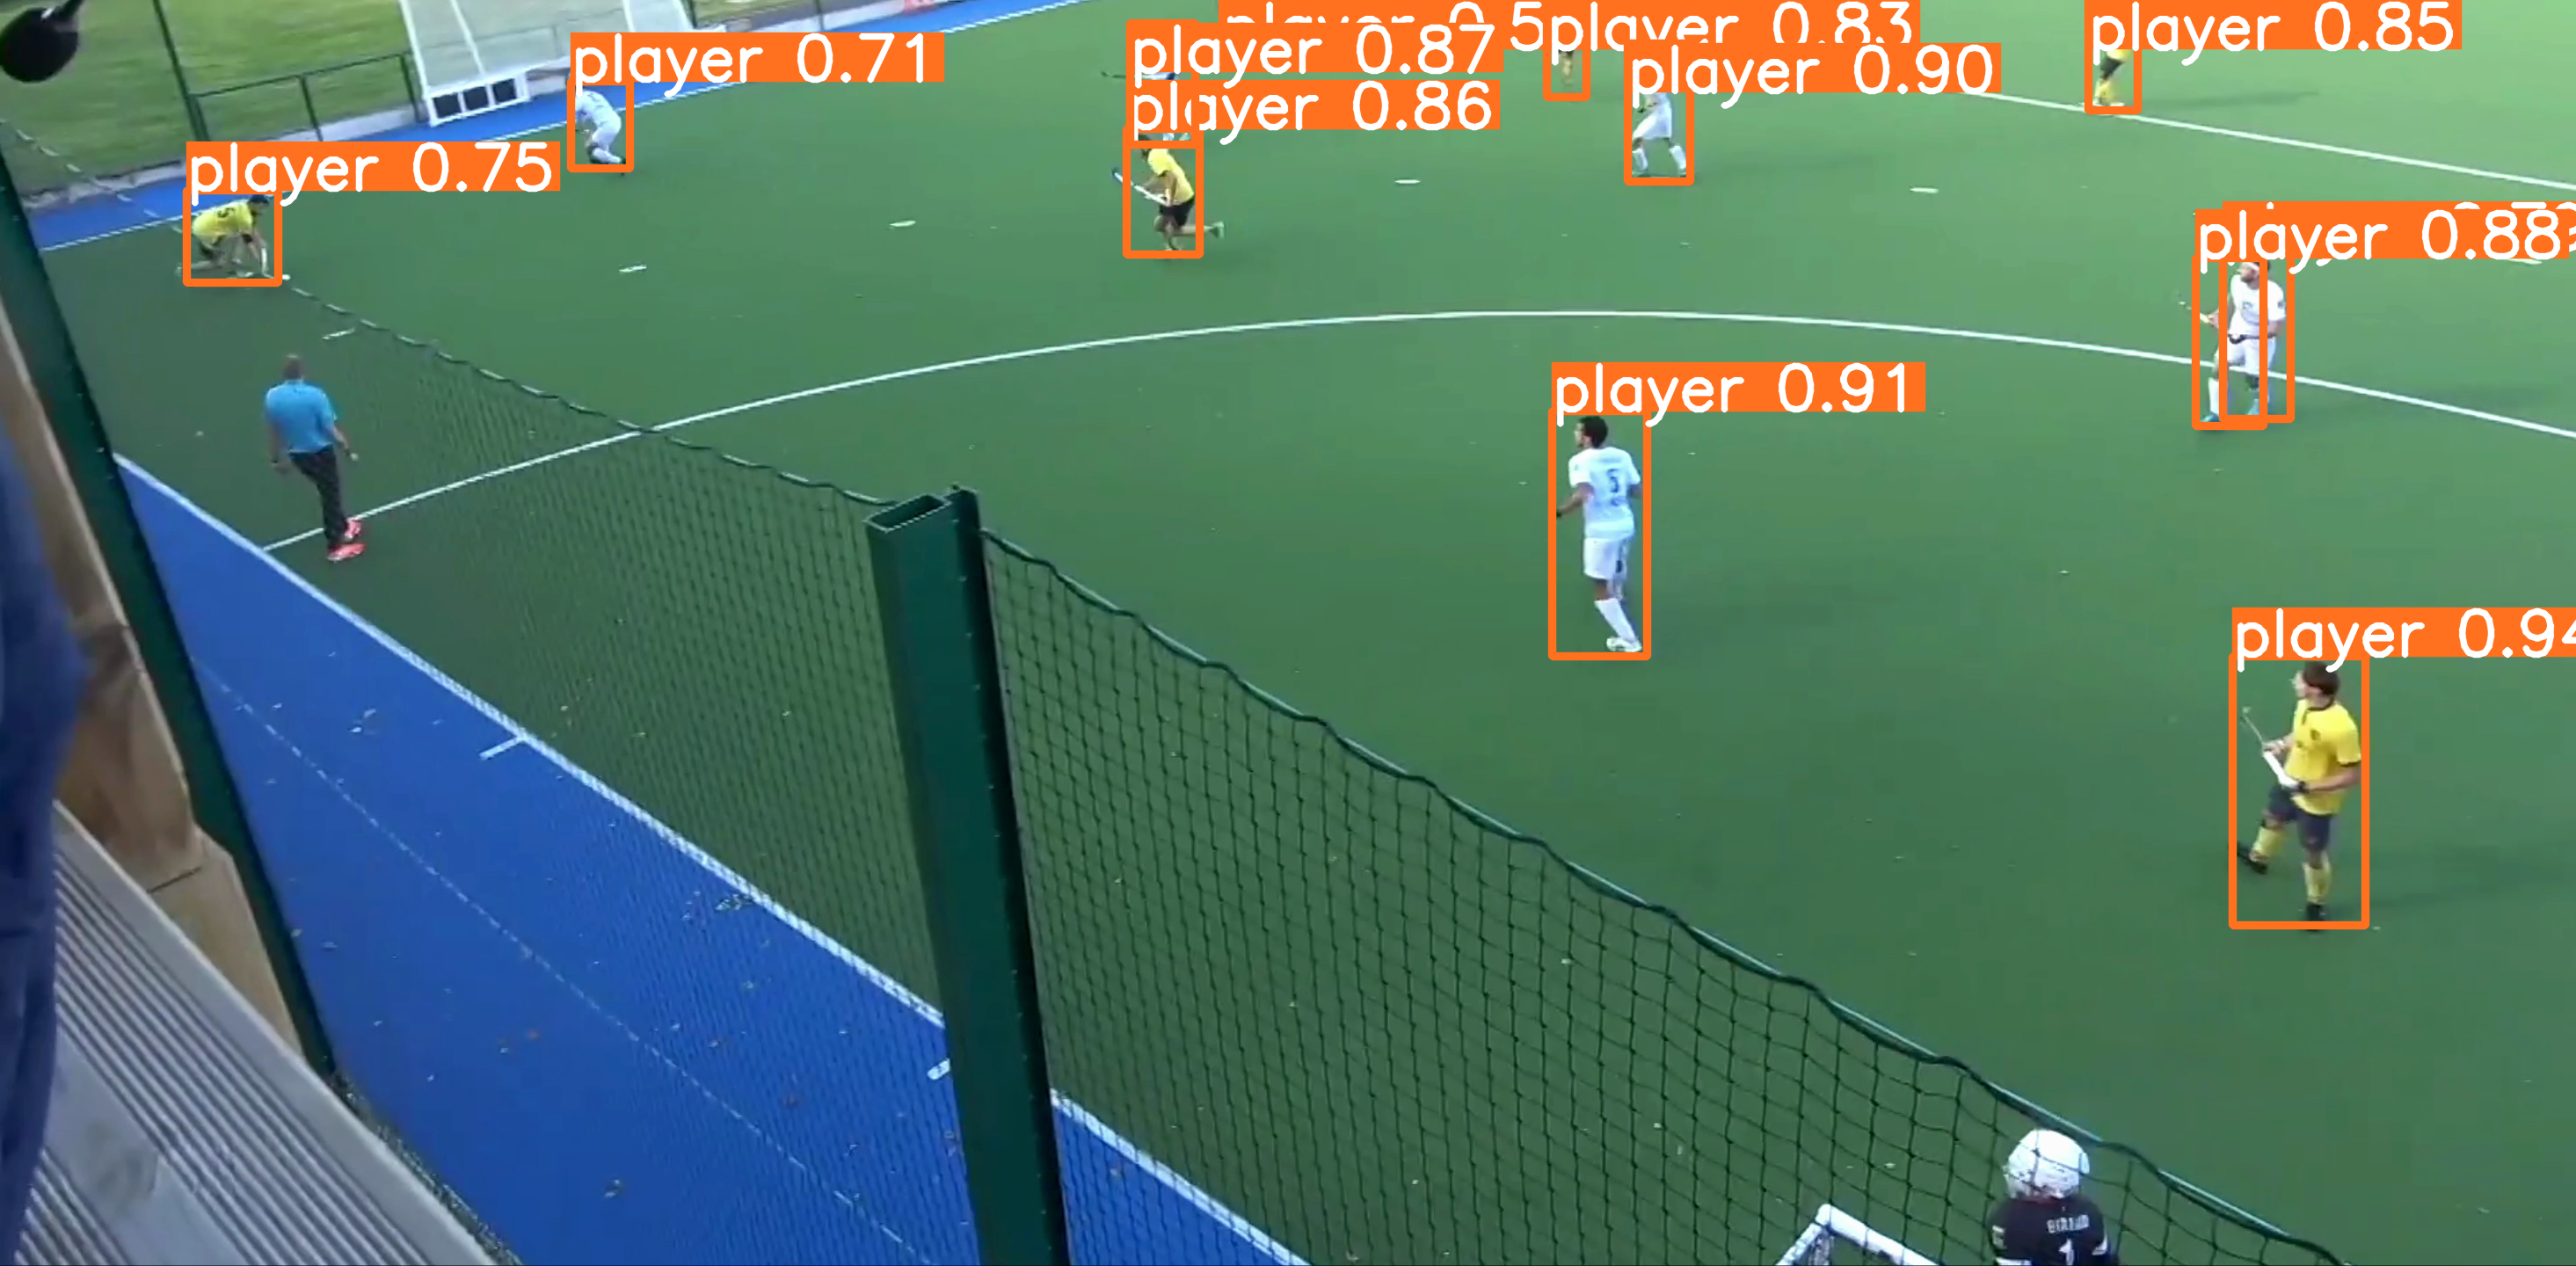

In [77]:
# Detect on a single frame from the video
FRAME_NUMBER = 500

detect_on_frame(MODEL_PATH, VIDEO_PATH, FRAME_NUMBER, 0.5)

In [62]:
def process_and_detect_on_video(model_path, video_path, output_path=None, display_video=False, conf_threshold=0.5):
    """Process a video file with YOLO model, optionally save and display the output.

    Args:
        model_path (str): Path to the YOLO model file.
        video_path (str): Path to the input video file.
        output_path (str, optional): Path where the output video will be saved. If None, the video won't be saved.
        display_video (bool): Whether to display the video during processing.
        conf_threshold (float): Confidence threshold for YOLO model detection.
    """

    model = YOLO(model_path)

    cap = cv2.VideoCapture(video_path)
    out = None
    if output_path:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    try:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            results = model(frame, conf=conf_threshold)
            annotated_frame = results[0].plot()

            if out:
                out.write(annotated_frame)

            if display_video:
                cv2.imshow("YOLOv8 Inference", annotated_frame)
                # Press Q on keyboard to exit when displaying the video
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        cap.release()
        if out:
            out.release()
        if display_video:
            cv2.destroyAllWindows()

In [68]:
process_and_detect_on_video(MODEL_PATH, VIDEO_PATH, OUTPUT_VIDEO_PATH, display_video=False, conf_threshold=0.5)


0: 320x640 16 players, 1 referee, 77.4ms
Speed: 1.7ms preprocess, 77.4ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 65.6ms
Speed: 1.2ms preprocess, 65.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 65.2ms
Speed: 1.1ms preprocess, 65.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 65.9ms
Speed: 1.2ms preprocess, 65.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 63.7ms
Speed: 1.2ms preprocess, 63.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 66.8ms
Speed: 1.2ms preprocess, 66.8ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 61.9ms
Speed: 1.1ms preprocess, 61.9ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 r

In [70]:
def track_players_in_video(model_path, video_path, output_path=None, display_video=False, conf_threshold=0.5):
    """Track objects in a video using YOLOv8 and optionally display the video with annotations.

    Args:
        model_path (str): Path to the YOLO model file.
        video_path (str): Path to the input video file.
        output_path (str, optional): Path where the output video will be saved. If None, the video won't be saved.
        display_video (bool): Whether to display the video during processing.
        conf_threshold (float): Confidence threshold for object tracking.
    """

    model = YOLO(model_path)

    cap = cv2.VideoCapture(video_path)
    out = None
    
    if output_path:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    try:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            results = model.track(frame, persist=True, conf=conf_threshold, tracker='bytetrack.yaml')
            annotated_frame = results[0].plot()
            
            if out:
                out.write(annotated_frame)

            if display_video:
                cv2.imshow("YOLOv8 Tracking", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        cap.release()
        if out:
            out.release()
        if display_video:
            cv2.destroyAllWindows()

In [71]:
track_players_in_video(MODEL_PATH, VIDEO_PATH, OUTPUT_VIDEO_PATH, display_video=False, conf_threshold=0.5)


0: 320x640 16 players, 1 referee, 73.3ms
Speed: 3.4ms preprocess, 73.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 68.1ms
Speed: 2.9ms preprocess, 68.1ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 69.7ms
Speed: 1.1ms preprocess, 69.7ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 66.8ms
Speed: 1.1ms preprocess, 66.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 66.2ms
Speed: 1.2ms preprocess, 66.2ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 66.0ms
Speed: 1.3ms preprocess, 66.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 referee, 80.9ms
Speed: 1.2ms preprocess, 80.9ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 15 players, 1 r